## **Imports**

In [89]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


## **Cargar archivos**

In [14]:
# CSV COVID-19
ruta_covid = "../../Data/Covid-19/covid-19_datos_por_comuna.csv"
df_covid = pd.read_csv(ruta_covid)
df_covid.head()

,Comuna,Año,Casos confirmados,Porcentaje promedio de cobertura de casos sospechosos,Total de casos positivos según el test PCR,Vacunados 1ra dosis,Vacunados 2da dosis,Vacunados dosis de refuerzo,Vacunados 4ta dosis,Vacunados unica dosis,Fallecidos por covid-19,Total fallecidos,Cant de transacciones BIP en 2020
0,Alhué,2020,16778.0,89.584211,99.0,0.0,0.0,0.0,0.0,0.0,6.0,83.0,NaN
1,Alhué,2021,70930.0,67.358824,271.4,7894.0,7538.0,5430.0,0.0,602.0,8.0,541.0,NaN
2,Alhué,2022,191187.0,88.466667,610.0,551.0,666.0,2516.0,6052.0,0.0,8.0,1088.0,NaN
3,Alhué,2023,5597.0,NaN,NaN,5.0,1.0,7.0,30.0,0.0,NaN,70.0,NaN
4,Buin,2020,160555.0,90.894737,90.1,0.0,0.0,0.0,0.0,0.0,158.0,1762.0,NaN


In [87]:
# CSV Nivel Socio Económico
ruta_nse = "../../Data/Nivel socioeconomico y geografico/Dataset_Socio_RM.csv"
df_nse = pd.read_csv(ruta_nse)
df_nse.head()

,Pobreza Categoria,Pobreza_multidimensional,Año,Sistema_previsional,NSE,region,Ingreso_hogar,Comuna,id_persona,pobreza_sinte
0,No Pobreza,0.0,2017,Fonasa,Medio,13.0,924350.0,Alhué,1,No aplica
1,No Pobreza,0.0,2017,Fonasa,Medio,13.0,924350.0,Alhué,1,No aplica
2,No Pobreza,0.0,2017,Otro sistema,Medio,13.0,924350.0,Alhué,1,No aplica
3,No Pobreza,0.0,2017,Isapre,Medio,13.0,924350.0,Alhué,1,No aplica
4,No Pobreza,0.0,2017,Fonasa,Medio,13.0,924350.0,Alhué,1,No aplica


In [16]:
# CSV Prestadores de salud
ruta_egresos = "../../Data/prestadores de salud/egresos_covid_todos.csv"
df_prestadores = pd.read_csv(ruta_egresos)
df_prestadores

,Sistema,Total_egresos,Egresos_COVID,%_COVID,%_COVID_num,Año
0,ISAPRE,373379,3903,1.05 %,1.045319,2020
1,FONASA,1277952,47081,3.68 %,3.684098,2020
2,ISAPRE,413087,8343,NaN,2.020000,2021
3,FONASA,1467062,89047,NaN,6.070000,2021
4,ISAPRE,468597,4034,NaN,0.860000,2022
5,FONASA,1540096,23980,NaN,1.560000,2022


In [17]:
# CSV Censo
ruta_censo = "../../Data/censo/estimacion_poblacion_por_comunas.csv"
df_censo = pd.read_csv(ruta_censo)
df_censo.head()

,Comuna,Año,Población
0,Santiago,2017,411183.000000
1,Santiago,2018,415136.285714
2,Santiago,2019,419089.571429
3,Santiago,2020,423042.857143
4,Santiago,2021,426996.142857


## **Heatmap NSE por comuna**

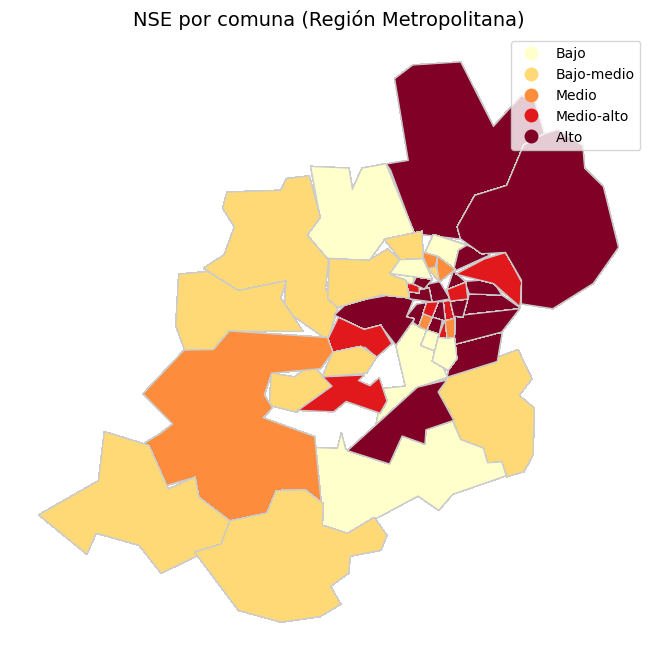

In [91]:

# Cargar el mapa de comuns
geo = gpd.read_file("Extra_Data/comunas.geojson")

# Filtrar la Región Metropolitana
geo_rm = geo[geo["codregion"] == 13].copy()

# Unir los df
geo_nse = geo_rm.merge(df_nse[["Comuna", "NSE"]], on="Comuna", how="left")

# Ordenar NSE
orden_nse = ['Bajo', 'Bajo-medio', 'Medio', 'Medio-alto', 'Alto']
geo_nse["NSE"] = pd.Categorical(geo_nse["NSE"], categories=orden_nse, ordered=True)

# Graficar
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

geo_nse.plot(
    column="NSE",
    cmap="YlOrRd",
    linewidth=0.8,
    edgecolor="0.8",
    legend=True,
    ax=ax
)

ax.set_title("NSE por comuna (Región Metropolitana)", fontsize=14)
ax.axis("off")

plt.show()


## **Gráficos Sistema de salud vs mortalidad**

### **Datos necesarios para los gráficos**

In [ ]:

# Limpiar df_nse
df_nse = df_nse.copy()
for c in ["Comuna", "Sistema_previsional"]:
    df_nse[c] = df_nse[c].astype(str).str.strip()

# Normalizar nombres
df_nse["Sistema_previsional"] = (
    df_nse["Sistema_previsional"]
    .str.title()
    .str.replace(r"\s+", " ", regex=True)
)

# Contar de personas por comuna y sistema
conteos = (
    df_nse.groupby(["Comuna","Sistema_previsional"])
          .size()
          .reset_index(name="n")
)

# Pivot para calcular % ISAPRE
pivot = conteos.pivot(index="Comuna", columns="Sistema_previsional", values="n").fillna(0)
for col in ["Fonasa","Isapre","Otro Sistema"]:
    if col not in pivot.columns:
        pivot[col] = 0

pivot["Total"] = pivot[["Fonasa","Isapre","Otro Sistema"]].sum(axis=1).replace(0, np.nan)
pivot["pct_isapre"] = pivot["Isapre"] / pivot["Total"] * 100

# Sistema predominante por comuna
predom = conteos.loc[conteos.groupby("Comuna")["n"].idxmax(), ["Comuna","Sistema_previsional"]]
predom = predom.rename(columns={"Sistema_previsional": "Sistema_predominante"})

sist_comuna = pivot.reset_index().merge(predom, on="Comuna", how="left")

# Calcular mortalidad comuna
df_covid = df_covid.copy()
df_covid = df_covid[df_covid["Año"].between(2020, 2022)]

mortalidad = (
    df_covid.groupby("Comuna", as_index=False)
            .agg({"Fallecidos por covid-19":"sum", "Total fallecidos":"sum"})
)
mortalidad["mort_covid_%"] = mortalidad["Fallecidos por covid-19"] / mortalidad["Total fallecidos"] * 100

# Unir
df_plot = sist_comuna.merge(mortalidad, on="Comuna", how="left")


### **Boxplot**

C:\Users\Equipo\AppData\Local\Temp\ipykernel_15124\3430861733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="Sistema_predominante", y="mort_covid_%", palette="pastel")


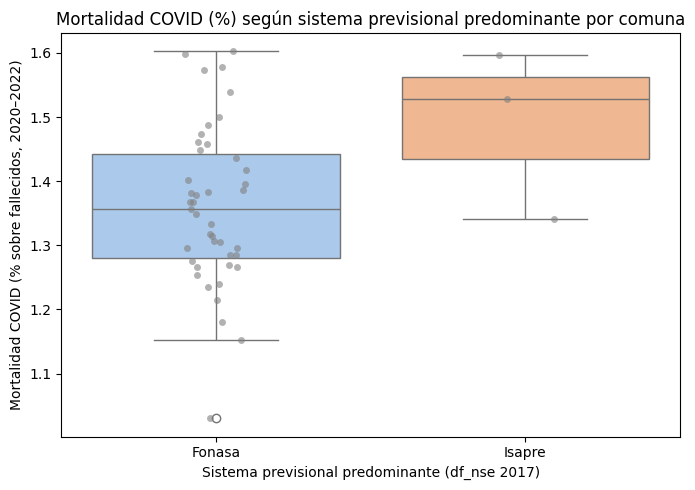

In [97]:

# Boxplot: mortalidad según sistema predominante
plt.figure(figsize=(7,5))
sns.boxplot(data=df_plot, x="Sistema_predominante", y="mort_covid_%", palette="pastel")
sns.stripplot(data=df_plot, x="Sistema_predominante", y="mort_covid_%", color="gray", alpha=0.6)
plt.title("Mortalidad COVID (%) según sistema previsional predominante por comuna")
plt.xlabel("Sistema previsional predominante (df_nse 2017)")
plt.ylabel("Mortalidad COVID (% sobre fallecidos, 2020–2022)")
plt.tight_layout()
plt.show()


### **Gráfico de dispersión % Isapre vs mortalidad**

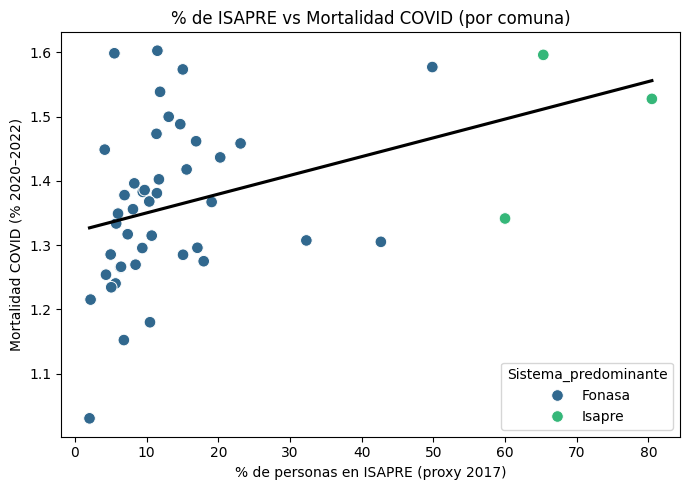

Correlación %ISAPRE ↔ mortalidad COVID: 0.392


In [92]:
# Dispersión: % ISAPRE vs mortalidad
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_plot, x="pct_isapre", y="mort_covid_%", hue="Sistema_predominante", palette="viridis", s=70)
sns.regplot(data=df_plot, x="pct_isapre", y="mort_covid_%", scatter=False, color="black", ci=None)
plt.title("% de ISAPRE vs Mortalidad COVID (por comuna)")
plt.xlabel("% de personas en ISAPRE (proxy 2017)")
plt.ylabel("Mortalidad COVID (% 2020–2022)")
plt.tight_layout()
plt.show()

# Correlación numérica
corr = df_plot[["pct_isapre", "mort_covid_%"]].corr().iloc[0,1]
print(f"Correlación %ISAPRE ↔ mortalidad COVID: {corr:.3f}")

### **Gráfico de dispersión % Fonasa vs mortalidad**

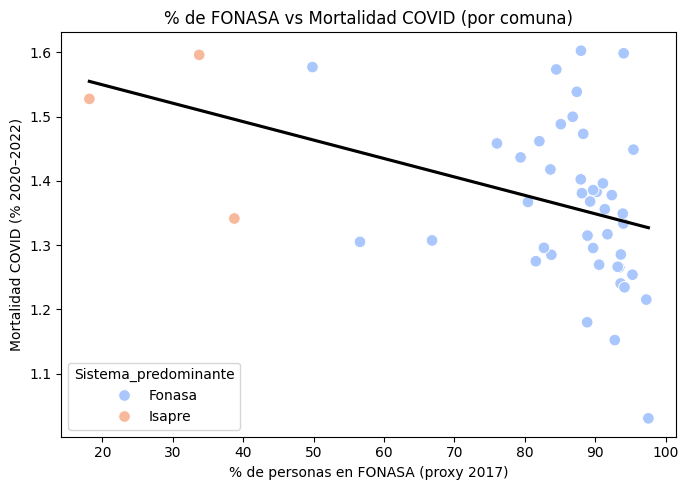

Correlación %FONASA ↔ mortalidad COVID: -0.388


In [93]:

# Dispersión: % FONASA vs mortalidad
df_plot["pct_fonasa"] = df_plot["Fonasa"] / df_plot["Total"] * 100

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_plot, x="pct_fonasa", y="mort_covid_%",
                hue="Sistema_predominante", palette="coolwarm", s=70)
sns.regplot(data=df_plot, x="pct_fonasa", y="mort_covid_%", scatter=False, color="black", ci=None)
plt.title("% de FONASA vs Mortalidad COVID (por comuna)")
plt.xlabel("% de personas en FONASA (proxy 2017)")
plt.ylabel("Mortalidad COVID (% 2020–2022)")
plt.tight_layout()
plt.show()

# Correlación 
corr_fonasa = df_plot[["pct_fonasa", "mort_covid_%"]].corr().iloc[0,1]
print(f"Correlación %FONASA ↔ mortalidad COVID: {corr_fonasa:.3f}")
